# Introducción

En un estudio sobre consumo de agua (m^2/mes) en cierta ciudad se supuso que el consumo estaría relacionado con el correspondiente consumo de energía eléctrica (kw/hr). Construya un modelo que relacione ambos consumos, considerando el consumo de agua como la respuesta.

# a) Grafique los datos y comente.

In [1]:
# Importación de librerías y configuraciones generales.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Options
# params = {'font.family':'STIXGeneral',
#           'text.usetex' : True,
#           'font.size' : 11,
#           #'figure.dpi':100
#           }
# plt.rcParams.update(params) 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [95]:
#Leer los datos del archivo `control2.dat` cuyas columnas están separadas por múltiples espacios.
df = pd.read_csv('control2.dat', sep='\s+')
df = df.set_index('obs.')

In [4]:
#display(df)

In [96]:
df.columns = ['Consumo de electricidad', 'Consumo de agua']
# display(df)

Primero, vamos a mencionar dos aspectos importantes de los datos con los que trabajaremos. Los datos proporcionados constan de 50 pares de observaciones y son variables continuas.

A continuación se presenta una gráfica que presenta los pares de las mediciones `Cantidad de electricidad` y `Cantidad de agua`, medidos en *kw/hr* y *m^2/mes* respectivamente, de cada observación.


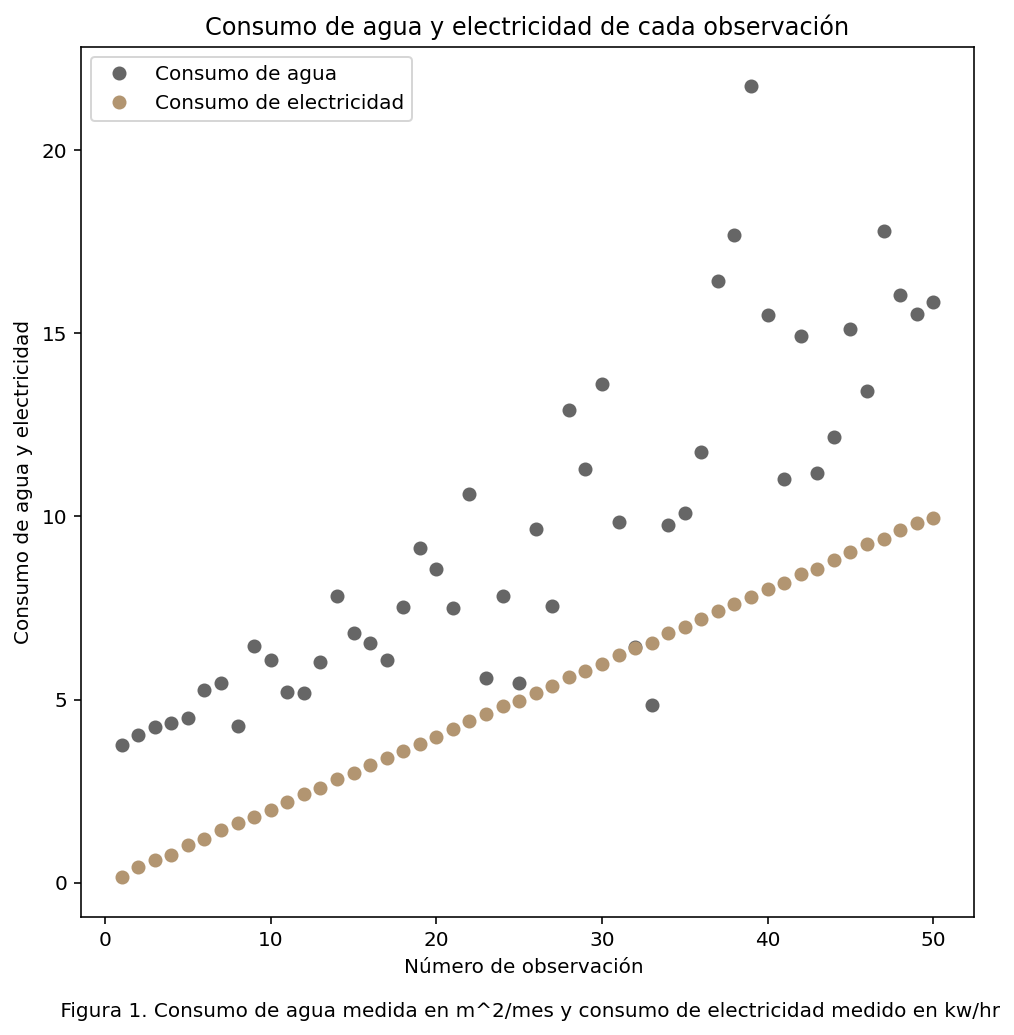

In [61]:
# x = range(1,51)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df['Consumo de agua'], 'o', color='#666666', label="Consumo de agua")
ax.plot(df['Consumo de electricidad'], 'o', color='#B29571', label="Consumo de electricidad")
# ax.fill_between(x, df['Consumo de agua'])
# ax.fill_between(x, df['Consumo de electricidad'])
# ax.axis('equal')

plt.title('Consumo de agua y electricidad de cada observación')
plt.xlabel('Número de observación \n\n Figura 1. Consumo de agua medida en m^2/mes y consumo de electricidad medido en kw/hr')
plt.ylabel('Consumo de agua y electricidad')
leg = ax.legend()

Como podemos observar, ambos tipos de consumo tienen una tendencia creciente. Sin embargo, el `consumo de la electricidad` presenta cambios pequeños en cada observación, además, da la impresión de que el cambio es constante.

Por otro lado, a pesar de que el `consumo de agua` empieza con cambios pequeños y crecientes, después de la quinta observación podemos notar que se presentan cambios más grandes entre cada observación y no todos los consumos son mayores que los anteriores. En resumen, los valores del `consumo de agua` tienen más variabilidad que los del `consumo de electricidad`. 

# b) Ajuste un modelo de regresión lineal simple sobre los datos sin transformar.

In [62]:
from sklearn.linear_model import LinearRegression

Queremos encontrar un modelo lineal que nos diga el `Consumo de agua` dado que tenemos un `Consumo de electricidad` dado. Es decir nuestra variable independiente es el `Consumo de electricidad` y la variable dependiente es el `Consumo de agua`.

In [119]:
X = df['Consumo de electricidad'].values.reshape(-1,1)
y = df['Consumo de agua'].values.reshape(-1,1)

reg = LinearRegression().fit(X, y)
reg.score(X, y)

beta_0 = np.round(reg.coef_[0],2)
beta_1 = np.round(reg.intercept_,2)

print('Beta_0',beta_0)
print('Beta_1',beta_1)



Beta_0 [1.3]
Beta_1 [2.88]


El modelo que obtenemos es:

<p style="text-align: center;"> $y = 1.3 + 2.88X$ </p>





# c) Verifique su modelo via análisis de residuales. Comente.

Con el modelo que obtuvimos, obtenemos los siguientes datos, que muestran el consumo de agua observado (`y observada`), el consumo de agua esperado (`y esperada`) y el error residual entre ambos consumos (`error residual`). 

In [112]:
y_observada = df['Consumo de agua']
y_observada.name = 'y observada'
# print(y_observada)

y_esperada = df['Consumo de electricidad'].apply(lambda x: beta_0 + beta_1*x) # modelo
y_esperada.name = 'y esperada'
# print(y_esperada)

error_residual = y_observada - y_esperada
error_residual.name = 'error residual'
# print(error_residual)

# resultados = pd.DataFrame(data={'y observada': [y_observada], 'y esperada': [y_esperada], 'error residual': [error_residual]}, dtype=float)
# resultados = pd.DataFrame.from_records([{'y observada': y_observada, 'y esperada': y_esperada, 'error residual': error_residual}])
# display(resultados)

resultados = pd.concat([y_observada, y_esperada, error_residual], axis=1)
display(resultados)

,y observada,y esperada,error residual
obs.,,,
1,3.756385,1.7608,1.995585
2,4.048329,2.5672,1.481129
3,4.255507,3.1144,1.141107
4,4.373823,3.4888,0.885023
5,4.506255,4.2952,0.211055
6,5.264085,4.7272,0.536885
7,5.464962,5.4472,0.017762
8,4.286531,5.9944,-1.707869
9,6.457674,6.4840,-0.026326


In [ ]:
# modelo y = 1.3 + 2.88x

obs = pd.DataFrame (list(range(1,51)))
# print(obs)
modelo = obs.apply(lambda x: 1.3+2.88*x)
# print(modelo)

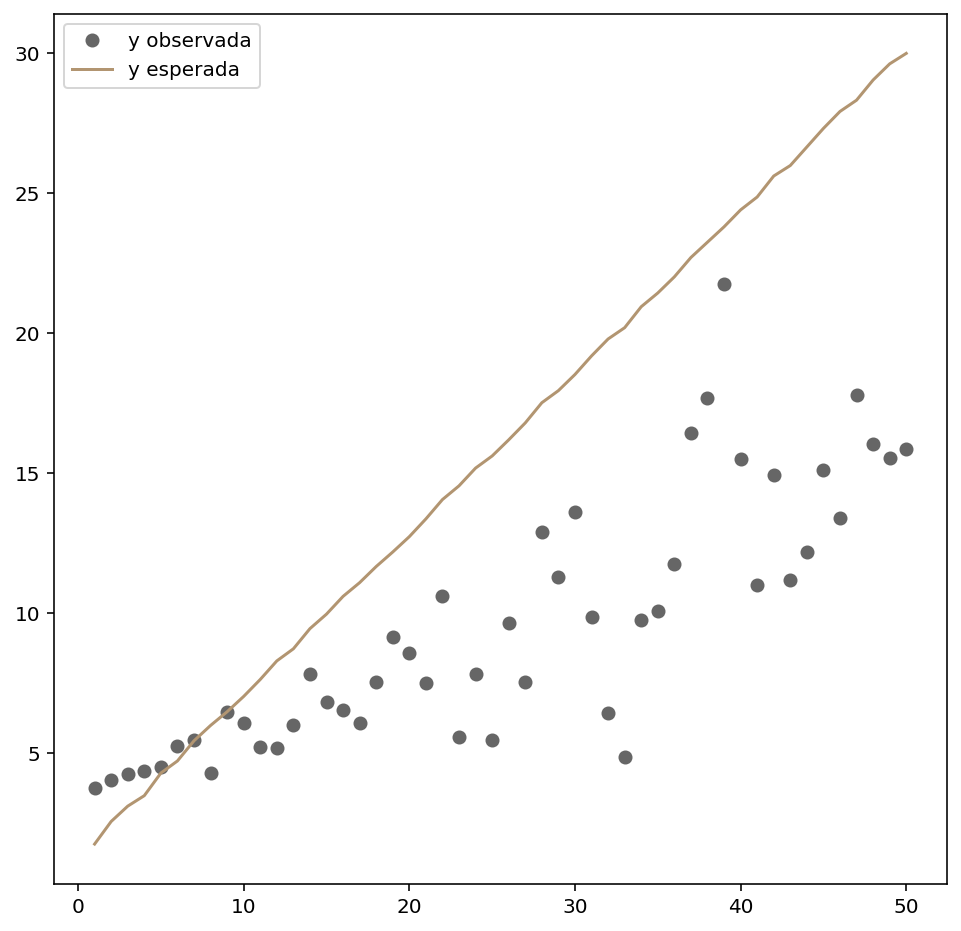

In [129]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(y_observada, 'o', color='#666666', label="y observada")
ax.plot(y_esperada, color='#B29571', label="y esperada")
# ax.fill_between(x, df['Consumo de agua'])
# ax.fill_between(x, df['Consumo de electricidad'])
# ax.axis('equal')

# plt.title('Consumo de agua y electricidad de cada observación')
# plt.xlabel('Número de observación \n\n Figura 1. Consumo de agua medida en m^2/mes y consumo de electricidad medido en kw/hr')
# plt.ylabel('Consumo de agua y electricidad')
leg = ax.legend()

# d) Aplique la transformación de Box-Cox y construya un intervalo del 90% de confianza para $\lambda$. ¿Que valor de $\lambda$ elegir ́ıa para la trasformación? Comente.

# e) Grafique $y^{(\lambda)}$ vs. $x$. Comente.

# f) Ajuste el modelo correspondiente y valídelo. Comente.

# g) Construya un intervalo del 90% confianza para el consumo **medio** esperado si el consumo de energía eléctrica es de 7.57 kw/hr. (Nota: el intervalo es para el consumo de agua, no la respuesta transformada.).

# h) Construya un intervalo de predicción de 95 % para la demanda esperada si la generación de energía es de 5.1 kw/hr.